In [1]:
#!pip install fasttext
!rm -rf ReST/
!git clone https://github.com/alessandrocuda/ReSt
!wget http://www.italianlp.it/twitter128.bin
!mv /content/twitter128.bin /content/ReSt/results/model/word2vec

Cloning into 'ReSt'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 345 (delta 126), reused 193 (delta 72), pack-reused 87
Receiving objects: 100% (345/345), 79.79 MiB | 29.06 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Checking out files: 100% (103/103), done.
--2021-04-11 15:57:35--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  27.7MB/s    in 24s     

2021-04-11 15:58:00 (23.9 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']  = "0"
os.environ['CUDA_VISIBLE_DEVICES'] 

'0'

In [2]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
#root_project = "/content/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/ReSt/"
root_project = "/storagenfs/a.cudazzo1/ReSt/"

sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token, load_data, to_emb
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb, get_index_key_pos_association, get_one_hot_pos
#load metrics
from src.utils.metrics import f1_macro
#load callbacks
from src.utils.callbacks import ReturnBestEarlyStopping, FCallback

from src.utils.utils import save_data_p, load_data_p, plotF1_macro, plotLoss, plotHistory
%load_ext autoreload
%autoreload 2

In [3]:
print(tf.__version__)

2.4.1


# Path

In [4]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

In [5]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [6]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# Embedding

In [7]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


In [8]:
# load pos embedding
index_to_key_pos, key_to_index_pos = get_index_key_pos_association(X = dataset_dev["pos"])
index_to_onehot_pos = get_one_hot_pos(index_to_key_pos)

In [9]:
index_to_onehot_pos

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 1: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 3: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 4: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 5: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 6: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 7: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 8: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 9: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 13: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 14: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 15: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 16: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [10]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# DATA

In [104]:
#load dev/test
MAX_TEXT_LEN = 65

X, X_pos, X_extra_feature, y = load_data(dataset_dev, w2v, key_to_index, key_to_index_pos, embedding_matrix, MAX_TEXT_LEN)
X_e = to_emb(X, embedding_matrix)
X_pos_e = to_emb(X_pos, index_to_onehot_pos)
#y  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y])

X_test, X_test_pos, X_test_extra_feature, y_test = load_data(dataset_test_tweets, w2v, key_to_index, key_to_index_pos, embedding_matrix, MAX_TEXT_LEN)
X_test_e = to_emb(X_test, embedding_matrix)
X_test_pos_e = to_emb(X_test_pos, index_to_onehot_pos)
#y_test  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y_test])

# Split

In [266]:
X_train, X_val, X_pos_train, X_pos_val, X_extra_feature_train, X_extra_feature_val, y_train, y_val = train_test_split(X_e, X_pos, X_extra_feature, y, test_size=0.10, random_state=128)


In [267]:
input_train = {"text": X_train, "pos": X_pos_train, "extra": X_extra_feature_train}
input_val = {"text": X_val, "pos": X_pos_val, "extra": X_extra_feature_val}
input_test = {"text": X_test_e, "pos": X_test_pos, "extra": X_test_extra_feature}

# model: text + pos + extra features

In [107]:
def bilstm_text_pos_extra(input_shape, bi_units = 256, dropout = 0.5, hn=128, lr=0.01, print_model=False):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Bidirectional, LSTM, Embedding
    from tensorflow.keras.layers import Dense, Input, Flatten, Activation
    from tensorflow.keras.layers import Concatenate
    from tensorflow.keras.regularizers import l2

    """ HyperParameters """

    text_seq_input = Input(shape=input_shape, name="text")
    pos_seq_input = Input(shape=(65, ), name="pos")
    pos_emb = Embedding(17, 16, input_length=65)(pos_seq_input)
    extra_feature = Input(shape=(8,), name="extra")

    sentence_encoder = Bidirectional(LSTM(bi_units, return_sequences=False))(text_seq_input)
    
    pos_encoder = Bidirectional(LSTM(bi_units, return_sequences=False))(pos_emb)

    input_ff    = Concatenate(axis=1)([sentence_encoder, pos_encoder, extra_feature])
    l_drop      = Dropout(dropout)(input_ff)
    l_hidden    = Dense(hn, activation='relu')(l_drop)
    l_drop      = Dropout(dropout)(l_hidden)
    #l_out_st    = Dense(2, activation='softmax', name="st")(l_drop)  #dims output
    l_out_st    = Dense(1, activation='sigmoid', name="st")(l_drop)  #dims output

    model_cnn   = Model(inputs=[text_seq_input, pos_seq_input, extra_feature], outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    
    model_cnn.compile(
        loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False),
        metrics= [f1_macro]
    )

    return model_cnn

In [108]:
#del model
model = bilstm_text_pos_extra((65,128, ), bi_units = 256, dropout = 0.7, hn=256, lr=0.0001, print_model=True)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos (InputLayer)                [(None, 65)]         0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 65, 128)]    0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 65, 16)       272         pos[0][0]                        
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 512)          788480      text[0][0]                       
____________________________________________________________________________________________

In [134]:
input_train = {"text": X_train, "pos": X_pos_train, "extra": X_extra_feature_train}
input_val = {"text": X_val, "pos": X_pos_val, "extra": X_extra_feature_val}
input_test = {"text": X_test_e, "pos": X_test_pos, "extra": X_test_extra_feature}

f1_callback = FCallback(validation = (input_test, y_test), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1_macro", min_delta=0, verbose=1, mode="max", restore_best_weights=True)

history = model.fit(input_train, y_train, batch_size=64, epochs=20, validation_data=(input_val, y_val), callbacks=[f1_callback, best_callback], verbose = 1)

Epoch 1/20
97/97 [==============================] - 8s 38ms/step - loss: 0.8332 - f1_macro: 0.4929 - val_loss: 0.6673 - val_f1_macro: 0.4573
— val_f1: 0.5350951997077843
Epoch 2/20
97/97 [==============================] - 2s 26ms/step - loss: 0.7802 - f1_macro: 0.5101 - val_loss: 0.6728 - val_f1_macro: 0.5276
— val_f1: 0.5871614995851248
Epoch 3/20
97/97 [==============================] - 2s 26ms/step - loss: 0.7264 - f1_macro: 0.5469 - val_loss: 0.6467 - val_f1_macro: 0.6210
— val_f1: 0.5658851038818328
Epoch 4/20
97/97 [==============================] - 2s 26ms/step - loss: 0.7042 - f1_macro: 0.5764 - val_loss: 0.6412 - val_f1_macro: 0.5996
— val_f1: 0.6283926166223237
Epoch 5/20
97/97 [==============================] - 3s 26ms/step - loss: 0.7009 - f1_macro: 0.6097 - val_loss: 0.6046 - val_f1_macro: 0.6489
— val_f1: 0.6631270769201805
Epoch 6/20
97/97 [==============================] - 2s 26ms/step - loss: 0.6447 - f1_macro: 0.6579 - val_loss: 0.5715 - val_f1_macro: 0.6863
— val_f1:

In [49]:
y_val_pred = np.where(model.predict(input_val) >0.6,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.7349451320230252
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       369
           1       0.73      0.68      0.71       315

    accuracy                           0.74       684
   macro avg       0.74      0.73      0.73       684
weighted avg       0.74      0.74      0.74       684



In [50]:
y_test_pred = np.where(model.predict(input_test) > 0.6, 1, 0)
print(y_test.shape)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

(1263,)
0.7147925490274794
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       694
           1       0.64      0.82      0.72       569

    accuracy                           0.71      1263
   macro avg       0.73      0.72      0.71      1263
weighted avg       0.74      0.71      0.71      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'f1_macro', 'val_loss', 'val_f1_macro', 'val_f1'])


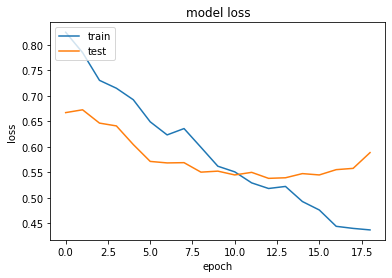

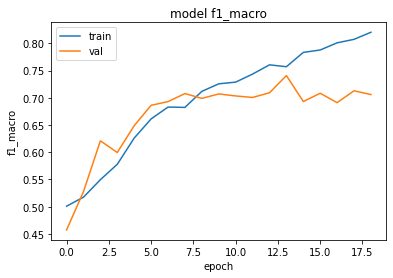

In [137]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['f1_macro'])
plt.plot(history.history['val_f1_macro'])
plt.title('model f1_macro')
plt.ylabel('f1_macro')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Result GridSearch

In [4]:
import pickle

grid_result = pickle.load( open( root_project + "script/grid_search/bilstm/final_grid_results.p", "rb" ) )

In [5]:
df_result = pd.DataFrame(grid_result)

In [10]:
pd.set_option('display.max_colwidth', None)
df_result_sorted = df_result.sort_values(by=['val_f1_macro_mean'], ascending=False)[0:3][["hyper_parm","loss_mean","loss_std","f1_macro_mean", "f1_macro_std","val_loss_mean","val_loss_std","val_f1_macro_mean","val_f1_macro_std"]]
df_result_sorted

,hyper_parm,loss_mean,loss_std,f1_macro_mean,f1_macro_std,val_loss_mean,val_loss_std,val_f1_macro_mean,val_f1_macro_std
220,"{'bi_units': 512, 'dropout': 0.7, 'hn': 128, 'lr': 0.001}",0.624485,0.138252,0.767335,0.014000,0.600199,0.047215,0.716635,0.006268
97,"{'bi_units': 128, 'dropout': 0.7, 'hn': 64, 'lr': 0.001}",0.622636,0.166698,0.792111,0.023957,0.600799,0.039763,0.714428,0.004377
175,"{'bi_units': 256, 'dropout': 0.9, 'hn': 256, 'lr': 0.001}",0.630948,0.155851,0.789268,0.022783,0.605851,0.037286,0.713450,0.007121


In [30]:
for ind in df_result_sorted.index:
    bi_units = df_result_sorted["hyper_parm"][ind]["bi_units"]
    dropout = df_result_sorted["hyper_parm"][ind]["dropout"]
    hn = df_result_sorted["hyper_parm"][ind]["hn"]
    lr = df_result_sorted["hyper_parm"][ind]["lr"]
    
    loss_mean         = df_result_sorted["loss_mean"][ind]
    loss_std          = df_result_sorted["loss_std"][ind]
    f1_macro_mean     = df_result_sorted["f1_macro_mean"][ind]
    f1_macro_std      = df_result_sorted["f1_macro_std"][ind]
    val_loss_mean     = df_result_sorted["val_loss_mean"][ind]
    val_loss_std      = df_result_sorted["val_loss_std"][ind]
    val_f1_macro_mean = df_result_sorted["val_f1_macro_mean"][ind]
    val_f1_macro_std  = df_result_sorted["val_f1_macro_std"][ind]
    print("{} & {} & {} & {} & $ {:.3f} \pm {:.3f} $ & $ {:.3f} \pm {:.3f} $ & $ {:.3f} \pm {:.3f} $ & $ {:.3f} \pm {:.3f} $".format(bi_units, dropout, hn, lr, loss_mean, loss_std, f1_macro_mean, f1_macro_std, val_loss_mean, val_loss_std, val_f1_macro_mean, val_f1_macro_std))


512 & 0.7 & 128 & 0.001 & $ 0.624 \pm 0.138 $ & $ 0.767 \pm 0.014 $ & $ 0.600 \pm 0.047 $ & $ 0.717 \pm 0.006 $
128 & 0.7 & 64 & 0.001 & $ 0.623 \pm 0.167 $ & $ 0.792 \pm 0.024 $ & $ 0.601 \pm 0.040 $ & $ 0.714 \pm 0.004 $
256 & 0.9 & 256 & 0.001 & $ 0.631 \pm 0.156 $ & $ 0.789 \pm 0.023 $ & $ 0.606 \pm 0.037 $ & $ 0.713 \pm 0.007 $


# Retrain the final model and save

In [268]:
model = bilstm_text_pos_extra((65,128, ), bi_units = 512, dropout = 0.7, hn=128, lr=0.001, print_model=False)
best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="min", restore_best_weights=True)
f1_call = FCallback(validation=(input_test, y_test), verbose=1)

history = model.fit(input_train, y_train, batch_size=64, epochs=20, validation_data=(input_val, y_val), callbacks=[f1_call, best_callback], verbose = 2)

Epoch 1/20
97/97 - 11s - loss: 0.7192 - f1_macro: 0.5485 - val_loss: 0.6369 - val_f1_macro: 0.6485
— val_f1: 0.6174686561976384
Epoch 2/20
97/97 - 5s - loss: 0.6443 - f1_macro: 0.6190 - val_loss: 0.5649 - val_f1_macro: 0.7048
— val_f1: 0.6310415252838945
Epoch 3/20
97/97 - 5s - loss: 0.6262 - f1_macro: 0.6529 - val_loss: 0.5663 - val_f1_macro: 0.6989
— val_f1: 0.6808216042666735
Epoch 4/20
97/97 - 5s - loss: 0.5882 - f1_macro: 0.6870 - val_loss: 0.5840 - val_f1_macro: 0.6782
— val_f1: 0.607822655447434
Epoch 5/20
97/97 - 5s - loss: 0.5485 - f1_macro: 0.7161 - val_loss: 0.5232 - val_f1_macro: 0.7237
— val_f1: 0.7025952602815625
Epoch 6/20
97/97 - 5s - loss: 0.5328 - f1_macro: 0.7297 - val_loss: 0.5789 - val_f1_macro: 0.7199
— val_f1: 0.6812553944306762
Epoch 7/20
97/97 - 5s - loss: 0.5103 - f1_macro: 0.7399 - val_loss: 0.5377 - val_f1_macro: 0.7261
— val_f1: 0.6584605162174273
Epoch 8/20
97/97 - 5s - loss: 0.4858 - f1_macro: 0.7609 - val_loss: 0.5268 - val_f1_macro: 0.7222
— val_f1: 0.6

In [299]:
y_train_pred = np.where(model.predict(input_train) > 0.5,1,0)
print(f1_score(y_train, y_train_pred, average="macro"))

y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))

y_test_pred = np.where(model.predict(input_test) > 0.5,1,0)
print(f1_score(y_test, y_test_pred, average="macro"))

0.7527863259653851
0.7269402472527473
0.7025952602815625


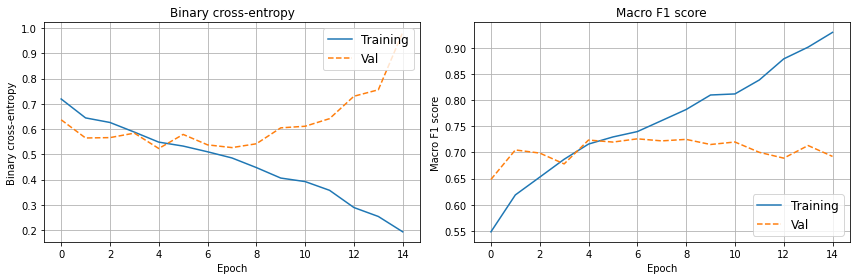

In [293]:
plotHistory(history.history)

In [295]:
model.save(root_project + 'results/model/d_bilstm/d_bilstm.h5')
save_data_p(history.history, root_project + 'results/model/d_bilstm/d_bilstm_history.p')

# Final model

In [309]:
dependencies = {
    'f1_macro': f1_macro
}
model = tf.keras.models.load_model(root_project + 'results/model/d_bilstm/d_bilstm.h5', custom_objects=dependencies)
model.compile(loss= tf.keras.losses.BinaryCrossentropy(), metrics= [f1_macro])
history = load_data_p(root_project + 'results/model/d_bilstm/d_bilstm_history.p')

In [310]:
model.evaluate(input_train, y_train)
model.evaluate(input_val, y_val)
model.evaluate(input_test, y_test)

40/40 [==============================] - 1s 17ms/step - loss: 0.5630 - f1_macro: 0.5736


[0.5630239844322205, 0.5736058950424194]

In [301]:
y_train_pred = np.where(model.predict(input_train) >0.5,1,0)
print(f1_score(y_train, y_train_pred, average="macro"))
print(classification_report(y_train, y_train_pred))

#y_train_pred = np.argmax(model.predict(input_train), axis = 1)
#print(f1_score(np.argmax(y_train, axis = 1), y_train_pred, average="macro"))
#print(classification_report(np.argmax(y_train, axis = 1), y_train_pred))

0.7527863259653851
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      3426
           1       0.70      0.77      0.74      2729

    accuracy                           0.75      6155
   macro avg       0.75      0.76      0.75      6155
weighted avg       0.76      0.75      0.75      6155



In [302]:
y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.7269402472527473
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       369
           1       0.70      0.72      0.71       315

    accuracy                           0.73       684
   macro avg       0.73      0.73      0.73       684
weighted avg       0.73      0.73      0.73       684



In [303]:
y_test_pred = np.where(model.predict(input_test) >0.5,1,0)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

0.7025952602815625
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       694
           1       0.63      0.85      0.72       569

    accuracy                           0.70      1263
   macro avg       0.73      0.72      0.70      1263
weighted avg       0.74      0.70      0.70      1263



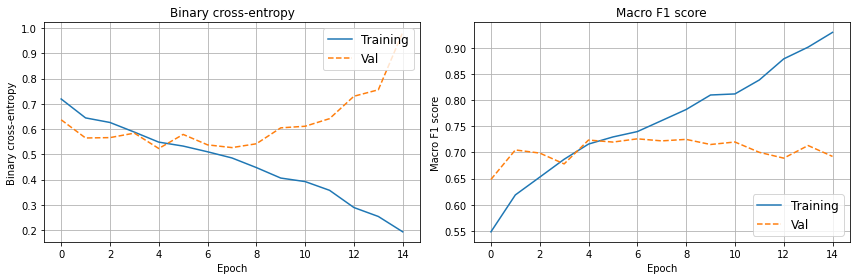

In [304]:
plotHistory(history)

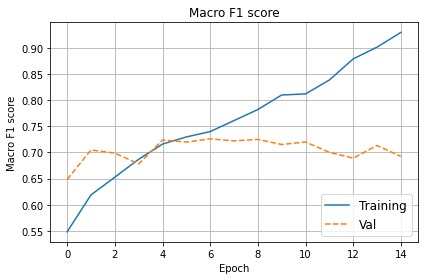

In [306]:
plotF1_macro(history)

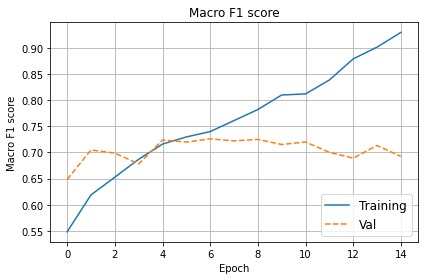

In [307]:
plotF1_macro(history)

# ----------------------------------------------

# ensemble predictions

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [29]:
kf = KFold(n_splits=5, shuffle=True)

models = []

data = {"text": X_e, "pos": X_pos_e, "extra": X_extra_feature, "target": y}
data_test = {"text": X_test_e, "pos": X_test_pos_e, "extra": X_test_extra_feature, "target": y_test}
i=1
for train_index_fold, val_index_fold in kf.split(data["text"]):
        name_fold = "fold_{}".format(i)
        print(name_fold)
        i+=1
        
        #DATA
        X_train = {"text": data["text"][train_index_fold], "pos": data["pos"][train_index_fold], "extra": data["extra"][train_index_fold]}
        Y_train = data["target"][train_index_fold]
        X_val = {"text": data["text"][val_index_fold], "pos": data["pos"][val_index_fold], "extra": data["extra"][val_index_fold]}
        Y_val = data["target"][val_index_fold]

        #print(hyper_param)
        input_shape = (X_train["text"][0].shape[0], X_train["text"][0].shape[1],)
        model = kim_cnn_pos((65,128, ), filters = 256, filter_sizes = [2,3,4], dropout = 0.5, hn=64, lr=0.0001, print_model=False)
        best_callback = ReturnBestEarlyStopping(monitor="val_loss", patience=50, verbose=0, mode="min", restore_best_weights=True)
        history = model.fit(X_train, Y_train, batch_size=64, epochs=200, validation_data=(X_val, Y_val), callbacks=[best_callback], verbose = 0)
        
        models.append(model)
        X_test = {"text": data_test["text"], "pos": data_test["pos"], "extra": data_test["extra"]}
        y_pred = np.where(model.predict(X_test) >0.5,1,0)

        print(f1_score(data_test["target"], y_pred, average="macro"))

fold_1
0.6884699604842567
fold_2
0.6800970162902645
fold_3
0.6804990508898421
fold_4
0.6906347344301067
fold_5
0.6883460236886633


In [37]:
def ensemble_predictions(members, X):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(X) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats[:,0])
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [38]:
X_test = {"text": data_test["text"], "pos": data_test["pos"], "extra": data_test["extra"]}
y_pred = ensemble_predictions(models, X_test)
print(classification_report(y_test,y_pred))


[0 0 0 0 0]
(5, 1263)
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       694
           1       0.61      0.83      0.71       569

    accuracy                           0.69      1263
   macro avg       0.71      0.70      0.69      1263
weighted avg       0.72      0.69      0.69      1263

